## Fake 3D maps

+ Create and compare tapered and non-tapered maps
+ Create PPV cubes with constant density 
+ Calculate and compare the structure functions

In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import json
import cmasher as cmr
import seaborn as sns
import sys
import pylab as pl

from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve_fft

from turbustat.simulator import make_ppv
from spectral_cube import SpectralCube  

sys.path.insert(1, 'C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules')  
from turb_utils import make_extended, make_3dfield
import strucfunc
import bfunc

In [3]:
## Basic Parameters
r0 = 32.0
N = 256
m = 0.30

In [4]:
## 3D non-tapered map

velocity_nt = make_3dfield(
    N,
    ellip=0.5,
    theta=45,  
    powerlaw=3.0 + m,
    randomseed=2021_10_08)* u.km / u.s 

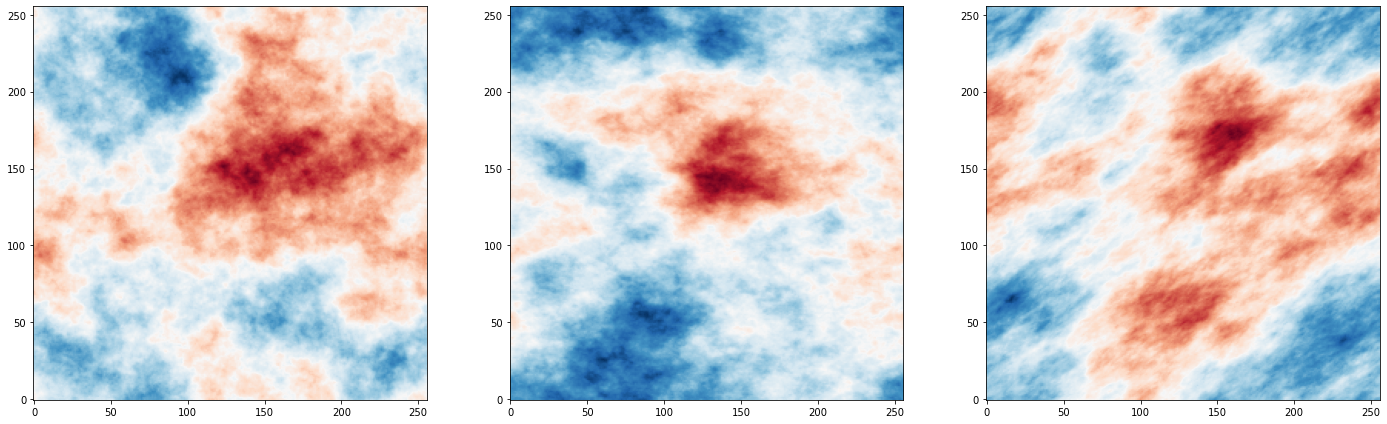

In [5]:
plt.figure(figsize=[20, 6])  
plt.subplot(131)  
plt.imshow(velocity_nt.mean(0).value, origin='lower', cmap="RdBu_r")  
plt.subplot(132)  
plt.imshow(velocity_nt.mean(1).value, origin='lower',cmap="RdBu_r")  
plt.subplot(133)  
plt.imshow(velocity_nt.mean(2).value, origin='lower',cmap="RdBu_r")  
plt.tight_layout()  

In [6]:
## 3D tapered velocity map

velocity = make_3dfield(
    N,
    ellip=0.5,
    theta=45,
    correlation_length=r0,  
    powerlaw=3.0 + m,
    randomseed=2021_10_08)* u.km / u.s  

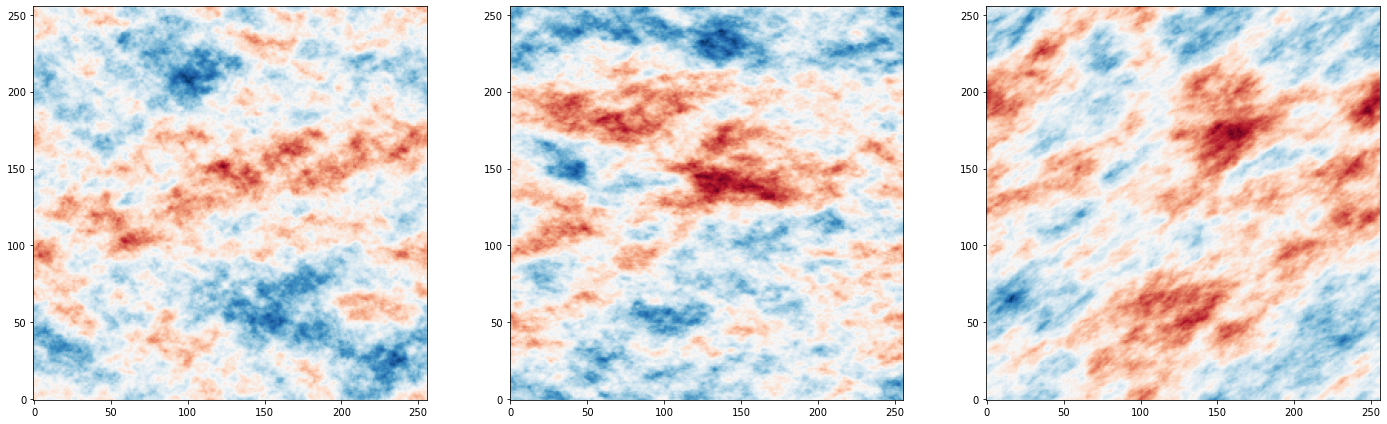

In [7]:
plt.figure(figsize=[20, 6])  
plt.subplot(131)  
plt.imshow(velocity.mean(0).value, origin='lower', cmap="RdBu_r")  
plt.subplot(132)  
plt.imshow(velocity.mean(1).value, origin='lower',cmap="RdBu_r")  
plt.subplot(133)  
plt.imshow(velocity.mean(2).value, origin='lower',cmap="RdBu_r")  
plt.tight_layout()  

In [8]:
## Constant density

#density = np.ones((N,N,N))* u.cm**-3  
#n = 100
#density *= n
#density += density.std()  
#density[density.value < 0.] = 0. * u.cm**-3  

## Emissivity fluctuations

density = make_3dfield(N, 
                       powerlaw=3.0 + m, 
                       amp=1.,
                       ellip=0.5,
                       theta=45,
                       correlation_length=r0,  
                       randomseed=328764) * u.cm**-3  

density = (density-density.mean())/density.std()

sig_E = 1
emissivity = np.exp(sig_E * density)* u.cm**-3

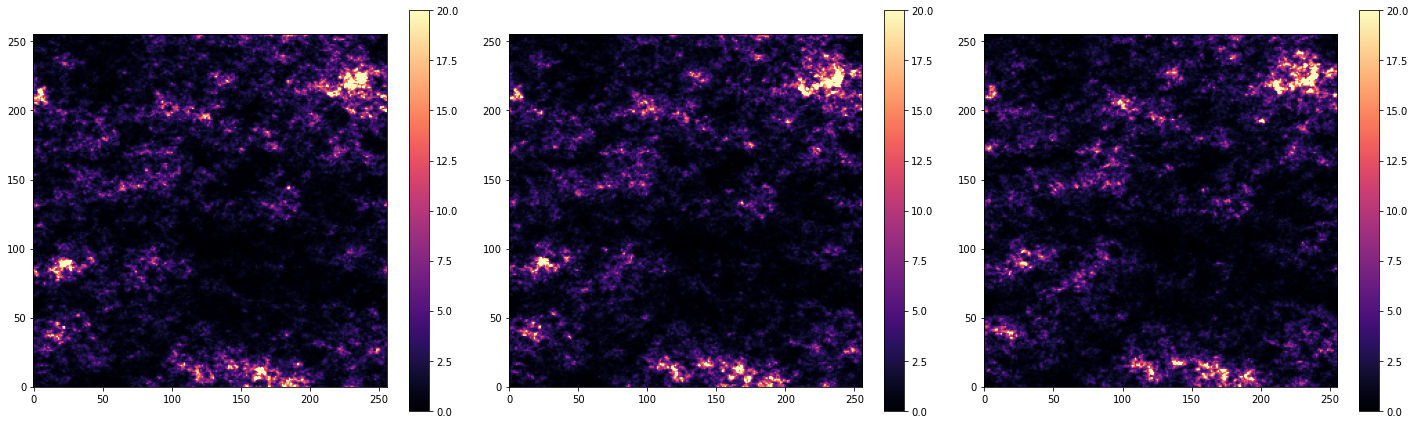

In [9]:
plt.figure(figsize=[20, 6])  
plt.subplot(131)  
plt.imshow(emissivity[0].value, origin='lower', cmap="magma") 
plt.colorbar()
plt.clim(0,20)
plt.subplot(132)  
plt.imshow(emissivity[1].value, origin='lower',cmap="magma")  
plt.colorbar()
plt.clim(0,20)
plt.subplot(133)  
plt.imshow(emissivity[2].value, origin='lower',cmap="magma")  
plt.colorbar()
plt.clim(0,20)
plt.tight_layout()  

In [10]:
##Non-tapered cube
cube_hdu_nt = make_ppv(velocity_nt, emissivity, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

cube_nt = SpectralCube.read(cube_hdu_nt)  

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


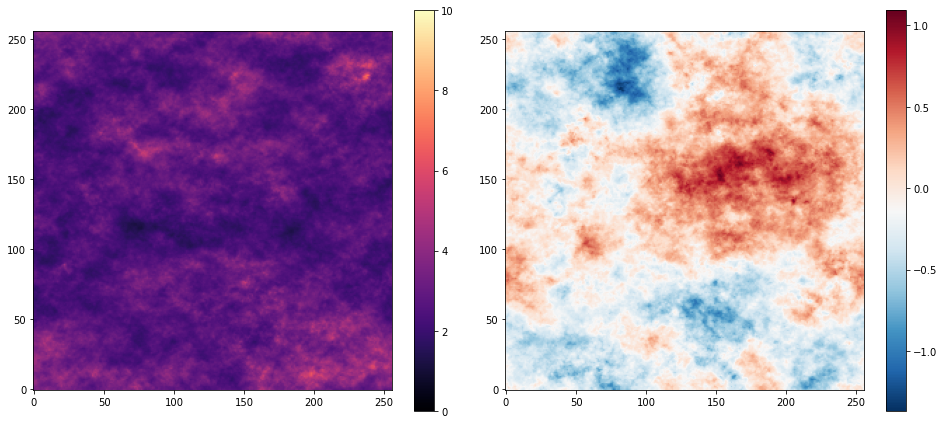

In [11]:
plt.figure(figsize=[20, 6])  
plt.subplot(131)  
plt.imshow(cube_nt.moment0().value, origin='lower', cmap="magma")  
plt.colorbar()
plt.clim(0,10)

plt.subplot(132)  
plt.imshow(cube_nt.moment1().value, origin='lower',cmap="RdBu_r")  
plt.colorbar()
#plt.subplot(133)  
#plt.imshow(velocity_3.mean(2).value, origin='lower',cmap="RdBu_r")  
plt.tight_layout() 

In [12]:
#cube_nt.write('cube_fits//cube_nt_ems_fluct_m1_sigE_1.fits', format='fits')  

In [13]:
##Tapered Cube
cube_hdu = make_ppv(velocity, emissivity, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

cube = SpectralCube.read(cube_hdu)  

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


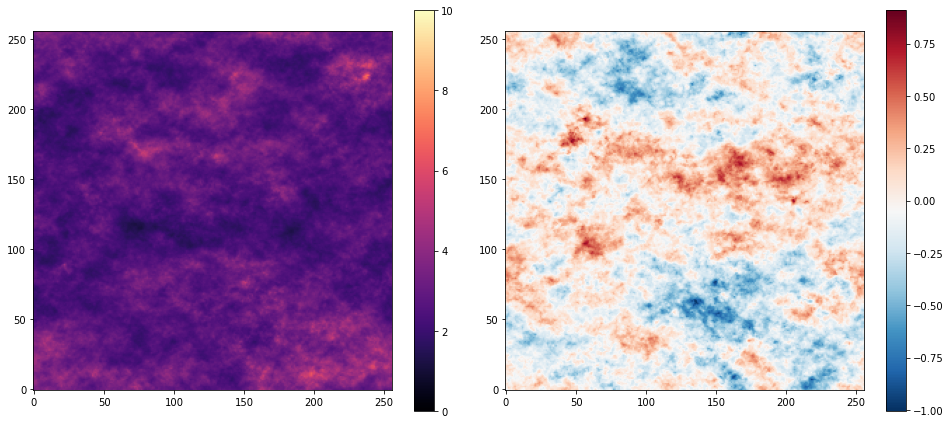

In [14]:
plt.figure(figsize=[20, 6])  
plt.subplot(131)  
plt.imshow(cube.moment0().value, origin='lower', cmap="magma")  
plt.colorbar()
plt.clim(0,10)

plt.subplot(132)  
plt.imshow(cube.moment1().value, origin='lower',cmap="RdBu_r")  
plt.colorbar()
#plt.subplot(133)  
#plt.imshow(velocity_3.mean(2).value, origin='lower',cmap="RdBu_r")  
plt.tight_layout() 

In [15]:
#cube.write('cube_fits//cube_ems_fluct_m1_sigE_1.fits', format='fits')  

### Structure Function

In [16]:
sf0 = strucfunc.strucfunc_numba_parallel(cube_nt.moment1().value,  wmap=cube_nt.moment0().value, dlogr=0.05)

C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [17]:
sf = strucfunc.strucfunc_numba_parallel(cube.moment1().value, wmap=cube.moment0().value, dlogr=0.05)

C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}


In [18]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [19]:
data_export = {
    'sf' : sf,
    'sf0' : sf0,
    't_moment1':cube.moment1().value,
    'nt_moment1':cube_nt.moment1().value
}

In [20]:
jsonfilename = "data_ems_fluct_sigE_1.json"
with open(jsonfilename, "w") as f:
    json.dump(data_export, fp=f, indent=3, cls=MyEncoder)

In [21]:
sns.set_context("talk", font_scale=0.8)


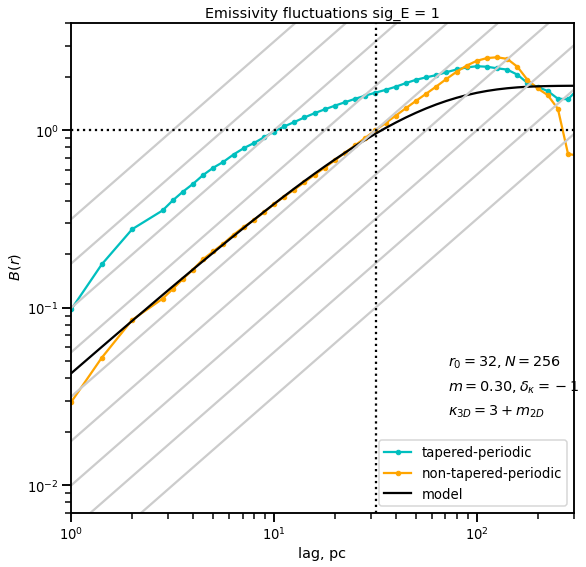

In [24]:
fig, ax = plt.subplots(
    figsize=(9, 9),
)
mask = sf["N pairs"] > 0
r = 10 ** sf["log10 r"][mask]
B = sf["Unweighted B(r)"][mask]
B0 = sf0["Unweighted B(r)"][mask]

#non-normalized
#ax.plot(r, B, marker=".", color="c")
#ax.plot(r, B0, marker=".", color="orange")
#normalized
ax.plot(r, B/ (cube.moment1().value).var(), marker=".", color="c", label= 'tapered-periodic')
ax.plot(r, B0/ (cube_nt.moment1().value).var(), marker=".", color="orange", label= 'non-tapered-periodic')

ax.plot(r, bfunc.bfunc04s(r, r0, (cube_nt.moment1().value).var(), 1, 0, 0, N)/(cube_nt.moment1().value).var(), color="black", label = 'model')
#ax.plot(r, bfunc.bfunc04s(r, r0, (cube.moment1().value).var(), m, 0, 0, N)/(cube.moment1().value).var(), color="red")

plt.title('Emissivity fluctuations sig_E = 1')

rgrid = np.logspace(-1.0, 2.5)
for a in np.logspace(-2.5, -0.5, 9):
    ax.plot(rgrid, a * rgrid ** 1, color="0.8")

ax.axhline(1.0, color="k", linestyle="dotted")
ax.axvline(r0, color="k", linestyle="dotted")
#ax.axvline(N / 2, color="k", linestyle="dashed")
#ax.axvline(N / 6, color="k", linestyle="dashed")
ax.set(xscale="log", yscale="log", 
       xlim=[1.0, 300], ylim=[7e-3, 4.0]
      )

ax.text(.75, .30,'$r_0 = 32, N = 256$', transform=ax.transAxes)
ax.text(.75, .25,'$m = 0.30, δ_{κ} = -1$', transform=ax.transAxes)
ax.text(.75, .20,'$κ_{3D} = 3 + m_{2D}$', transform=ax.transAxes)

ax.set(
       xlabel='lag, pc',
       ylabel=r' $B(r)$'
      )
plt.legend()

In [23]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 446.0918810367584 seconds ---
